In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


/var/folders/xf/z4195tzn5tq20kbd1dlbsg3m0000gn/T/ipykernel_1170/2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [4]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  func(*a

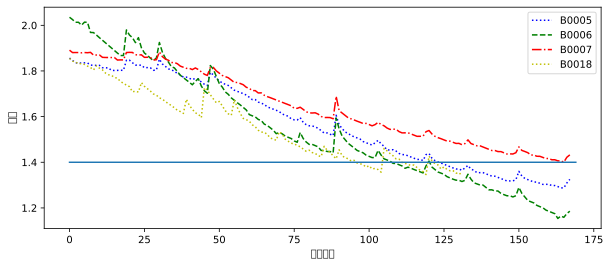

In [5]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [3]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 卡尔曼滤波

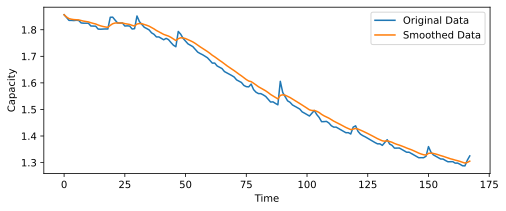

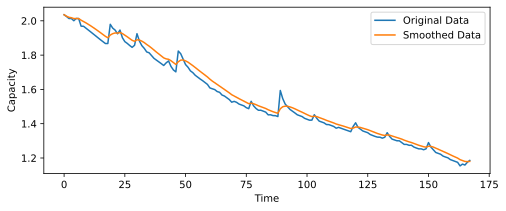

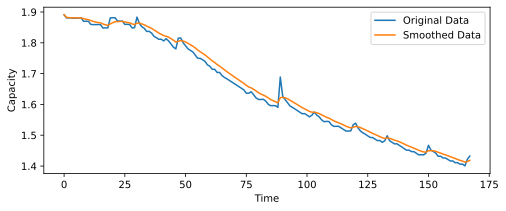

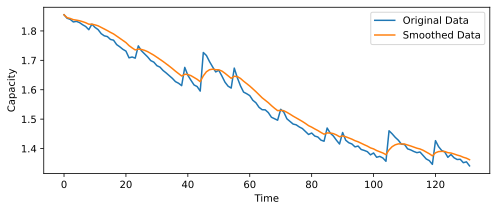

battery_index:0    , MAE:0.0162 , RMSE:0.0182 , RE:0.0240
battery_index:1    , MAE:0.0262 , RMSE:0.0298 , RE:0.0367
battery_index:2    , MAE:0.0137 , RMSE:0.0158 , RE:0.0000
battery_index:3    , MAE:0.0216 , RMSE:0.0252 , RE:0.0412


In [6]:
# Kalman滤波函数
def kalman_filter(data, process_variance, measurement_variance):
    # 初始化滤波器参数
    state = data[0]  # 初始状态
    state_estimate = state
    estimate_error = 1.0
    
    # 存储平滑后的数据
    smoothed_data = [state]
    
    for measurement in data[1:]:
        # 预测步骤
        prediction = state_estimate
        prediction_error = estimate_error + process_variance
        
        # 更新步骤
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        state_estimate = prediction + kalman_gain * (measurement - prediction)
        estimate_error = (1 - kalman_gain) * prediction_error
        
        # 存储平滑后的数据
        smoothed_data.append(state_estimate)
        state = state_estimate
    
    return np.array(smoothed_data)

Kalman_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data
    # 使用Kalman滤波
    process_variance = 0.01  # 系统噪音方差
    measurement_variance = 0.2  # 观测噪音方差
    smoothed_data = kalman_filter(original_data, process_variance, measurement_variance)
    Kalman_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 卡尔曼滤波后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, Kalman_battery_data_list):
    mae, rmse = evaluation(o_data, k_data)
    re = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

## 构建训练序列数据

In [7]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [8]:
train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, 0, window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 5, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([5, 16])
torch.Size([5, 16])
tensor([[2.0353, 2.0268, 2.0205, 2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960,
         1.9880, 1.9793, 1.9703, 1.9608, 1.9509, 1.9409, 1.9305],
        [2.0268, 2.0205, 2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880,
         1.9793, 1.9703, 1.9608, 1.9509, 1.9409, 1.9305, 1.9201],
        [2.0205, 2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880, 1.9793,
         1.9703, 1.9608, 1.9509, 1.9409, 1.9305, 1.9201, 1.9096],
        [2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880, 1.9793, 1.9703,
         1.9608, 1.9509, 1.9409, 1.9305, 1.9201, 1.9096, 1.9012],
        [2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880, 1.9793, 1.9703, 1.9608,
         1.9509, 1.9409, 1.9305, 1.9201, 1.9096, 1.9012, 1.9169]])
tensor([[2.0268, 2.0205, 2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880,
         1.9793, 1.9703, 1.9608, 1.9509, 1.9409, 1.9305, 1.9201],
        [2.0205, 2.0180, 2.0131, 2.0133, 2.0133, 2.0035, 1.9960, 1.9880, 1.97

## 绘制 out 和  tgt_y的对比图

In [9]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [10]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + Y
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16)
Y = blk(X)
Y.shape

torch.Size([50, 64, 16])

## 随机种子

In [11]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [13]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 16, 1])


## 一个批次的训练函数

In [14]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [15]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, Rated_Capacity)
            test_y = test_data.copy()
            
            mae, rmse = evaluation(test_y, pre_list)
            re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(seed, Battery_list[i], epoch, train_loss, mae, rmse, re))
            # print('out is ')
            # print(len(out))
            # print('tgt_y is ')
            # print(len(tgt_y))
            
            
            # matlab_make(pre_list, test_y)
            
            #print('epoch:{:<4d} , loss:{:<6.10f} '.format(epoch, train_loss))
            
            if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
                break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [16]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练

In [17]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.0001
weight_decay = 0.00001
num_epochs = 2000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s = [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:99   , loss:0.0052712369 , MAE:0.2203 , RMSE:0.2674 , RE:0.3945
seed: 0, 测试集: B0005, epoch:199  , loss:0.0026139822 , MAE:0.2253 , RMSE:0.2754 , RE:0.3945
seed: 0, 测试集: B0005, epoch:299  , loss:0.0015032350 , MAE:0.1559 , RMSE:0.1879 , RE:0.3945
seed: 0, 测试集: B0005, epoch:399  , loss:0.0011154880 , MAE:0.2683 , RMSE:0.3204 , RE:0.3945
seed: 0, 测试集: B0005, epoch:499  , loss:0.0006486239 , MAE:0.2663 , RMSE:0.3181 , RE:0.3945
seed: 0, 测试集: B0005, epoch:599  , loss:0.0005967705 , MAE:0.0283 , RMSE:0.0331 , RE:0.0642
seed: 0, 测试集: B0005, epoch:699  , loss:0.0005051221 , MAE:0.0321 , RMSE:0.0354 , RE:0.1101
以电池 B0006 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0006, epoch:99   , loss:0.0034220410 , MAE:0.2794 , RMSE:0.3270 , RE:0.6344
seed: 0, 测试集: B0006, epoch:199  , loss:0.0022626952 , MAE:0.3984 , RMSE:0.4490 , RE:0.6344


seed: 1, 测试集: B0018, epoch:699  , loss:0.0008635201 , MAE:0.1855 , RMSE:0.2002 , RE:0.4321
seed: 1, 测试集: B0018, epoch:799  , loss:0.0005666001 , MAE:0.0343 , RMSE:0.0414 , RE:0.0370
seed: 1, 测试集: B0018, epoch:899  , loss:0.0005799306 , MAE:0.0443 , RMSE:0.0563 , RE:0.0494
---------------------------------
re_s [0.045871559633027525, 0.10752688172043011, 0.125, 0.037037037037037035]
---------------------------------
re mean: 0.07885886959762367
mae mean: 0.03997402554525904
rmse mean: 0.04737299015822234
---------------------------------
*******************************************************************************************************************
当前的 seed 为 2
以电池 B0005 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0005, epoch:99   , loss:0.0069383830 , MAE:0.3626 , RMSE:0.4125 , RE:0.3945
seed: 2, 测试集: B0005, epoch:199  , loss:0.0034131601 , MAE:0.2811 , RMSE:0.3335 , RE:0.3945
seed: 2, 测试集: B0005, epoch:299  , loss:0.0020123888 , MAE:0.1844 , RMSE:0.2204 , RE:0.3945
seed: 2, 测试集: B0005, epoch:39

seed: 3, 测试集: B0007, epoch:1299 , loss:0.0002233438 , MAE:0.0561 , RMSE:0.0656 , RE:0.2434
以电池 B0018 为测试数据的 数据集 开始训练
seed: 3, 测试集: B0018, epoch:99   , loss:0.0075817737 , MAE:0.3527 , RMSE:0.3837 , RE:0.4321
seed: 3, 测试集: B0018, epoch:199  , loss:0.0021087986 , MAE:0.4574 , RMSE:0.4936 , RE:0.4321
seed: 3, 测试集: B0018, epoch:299  , loss:0.0010076102 , MAE:0.2288 , RMSE:0.2498 , RE:0.4321
seed: 3, 测试集: B0018, epoch:399  , loss:0.0096620452 , MAE:0.1647 , RMSE:0.1760 , RE:0.4321
seed: 3, 测试集: B0018, epoch:499  , loss:0.0007342933 , MAE:0.0867 , RMSE:0.0931 , RE:0.4321
seed: 3, 测试集: B0018, epoch:599  , loss:0.0004722788 , MAE:0.0562 , RMSE:0.0654 , RE:0.2469
seed: 3, 测试集: B0018, epoch:699  , loss:0.0004995467 , MAE:0.0612 , RMSE:0.0678 , RE:0.4321
seed: 3, 测试集: B0018, epoch:799  , loss:0.0006936993 , MAE:0.0371 , RMSE:0.0416 , RE:0.1358
seed: 3, 测试集: B0018, epoch:899  , loss:0.0001667658 , MAE:0.0875 , RMSE:0.0934 , RE:0.4321
---------------------------------
re_s [0.10091743119266056, 0.1

seed: 6, 测试集: B0005, epoch:299  , loss:0.0020160298 , MAE:0.1036 , RMSE:0.1103 , RE:0.3486
seed: 6, 测试集: B0005, epoch:399  , loss:0.0013933098 , MAE:0.2465 , RMSE:0.2926 , RE:0.3945
seed: 6, 测试集: B0005, epoch:499  , loss:0.0013564433 , MAE:0.0339 , RMSE:0.0414 , RE:0.0459
seed: 6, 测试集: B0005, epoch:599  , loss:0.0010910472 , MAE:0.2036 , RMSE:0.2107 , RE:0.4771
seed: 6, 测试集: B0005, epoch:699  , loss:0.0005460941 , MAE:0.0858 , RMSE:0.0897 , RE:0.2294
seed: 6, 测试集: B0005, epoch:799  , loss:0.0007006527 , MAE:0.3145 , RMSE:0.3403 , RE:0.5413
seed: 6, 测试集: B0005, epoch:899  , loss:0.0003141110 , MAE:0.1590 , RMSE:0.1636 , RE:0.3853
seed: 6, 测试集: B0005, epoch:999  , loss:0.0003798738 , MAE:0.1036 , RMSE:0.1072 , RE:0.2385
seed: 6, 测试集: B0005, epoch:1099 , loss:0.0003870063 , MAE:0.0510 , RMSE:0.0595 , RE:0.3578
seed: 6, 测试集: B0005, epoch:1199 , loss:0.0002435351 , MAE:0.0429 , RMSE:0.0519 , RE:0.0275
seed: 6, 测试集: B0005, epoch:1299 , loss:0.0001573971 , MAE:0.1692 , RMSE:0.1810 , RE:0.3394

seed: 7, 测试集: B0007, epoch:399  , loss:0.0017226186 , MAE:0.0784 , RMSE:0.0846 , RE:0.2368
seed: 7, 测试集: B0007, epoch:499  , loss:0.0012260014 , MAE:0.2795 , RMSE:0.3227 , RE:0.0000
seed: 7, 测试集: B0007, epoch:599  , loss:0.0006344648 , MAE:0.2312 , RMSE:0.2676 , RE:0.0000
seed: 7, 测试集: B0007, epoch:699  , loss:0.0005151598 , MAE:0.0461 , RMSE:0.0536 , RE:0.0000
seed: 7, 测试集: B0007, epoch:799  , loss:0.0002755514 , MAE:0.0451 , RMSE:0.0551 , RE:0.0000
seed: 7, 测试集: B0007, epoch:899  , loss:0.0002964015 , MAE:0.0234 , RMSE:0.0300 , RE:0.0000
seed: 7, 测试集: B0007, epoch:999  , loss:0.0001812534 , MAE:0.0486 , RMSE:0.0566 , RE:0.0000
seed: 7, 测试集: B0007, epoch:1099 , loss:0.0002277102 , MAE:0.0864 , RMSE:0.0932 , RE:0.3355
seed: 7, 测试集: B0007, epoch:1199 , loss:0.0001695746 , MAE:0.0249 , RMSE:0.0303 , RE:0.0592
seed: 7, 测试集: B0007, epoch:1299 , loss:0.0001222539 , MAE:0.1137 , RMSE:0.1183 , RE:0.3882
以电池 B0018 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0018, epoch:99   , loss:0.0054381220 , MAE:0.4373

seed: 9, 测试集: B0006, epoch:299  , loss:0.0012655513 , MAE:0.5213 , RMSE:0.5726 , RE:0.6344
seed: 9, 测试集: B0006, epoch:399  , loss:0.0009623494 , MAE:0.4677 , RMSE:0.5191 , RE:0.6344
seed: 9, 测试集: B0006, epoch:499  , loss:0.0008252684 , MAE:0.4009 , RMSE:0.4520 , RE:0.6344
seed: 9, 测试集: B0006, epoch:599  , loss:0.0005467596 , MAE:0.4203 , RMSE:0.4722 , RE:0.6344
seed: 9, 测试集: B0006, epoch:699  , loss:0.0005366990 , MAE:0.3838 , RMSE:0.4338 , RE:0.6344
seed: 9, 测试集: B0006, epoch:799  , loss:0.0002936337 , MAE:0.4236 , RMSE:0.4753 , RE:0.6344
seed: 9, 测试集: B0006, epoch:899  , loss:0.0002919383 , MAE:0.4111 , RMSE:0.4622 , RE:0.6344
seed: 9, 测试集: B0006, epoch:999  , loss:0.0003276685 , MAE:0.4421 , RMSE:0.4942 , RE:0.6344
seed: 9, 测试集: B0006, epoch:1099 , loss:0.0004209630 , MAE:0.4182 , RMSE:0.4683 , RE:0.6344
seed: 9, 测试集: B0006, epoch:1199 , loss:0.0002323859 , MAE:0.3797 , RMSE:0.4230 , RE:0.6344
seed: 9, 测试集: B0006, epoch:1299 , loss:0.0003429894 , MAE:0.5108 , RMSE:0.5662 , RE:0.6344